# Testing Kernel Density Estimation

## Simple Gaussian Curve

Loading ESS event mode toolkit (emtk)
Loading curves
Loading omega functions
Generated 5000 samples using parameters [5. 1.]
Adding flat background of 50000.0 points


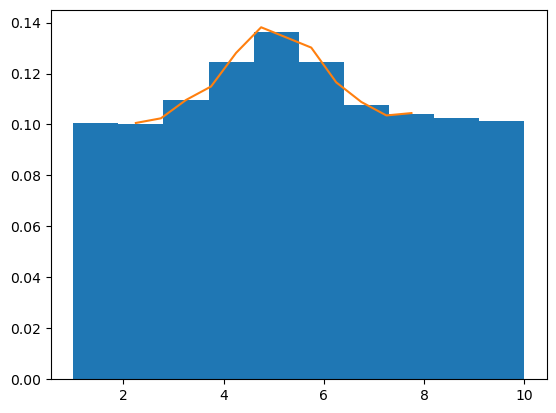

In [1]:
import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 5000)
curv.generate_background(xrange, 10.0)

#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(curv.data, density=True)
xgrid = np.arange(2, 8, 0.5)
#xgrid = hh[1]
xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)
ax.plot(xgrid, yvals)

In [2]:
# The normalisation of the histogram and kde are "density" but we need to be careful
# Exactly what does that mean?  What is the normalisation factor?  Then we can use the
# density exactly as a probability to discard points in proportion to the background measurement.

# The hist density=True code is given here:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html#matplotlib.pyplot.hist
# It's obvious from the curves above that the two codes are doing the same thing.

# If True, draw and return a probability density: each bin will display the bin's raw count 
# divided by the total number of counts and the bin width 

# (density = counts / (sum(counts) * np.diff(bins))), 

# so that the area under the histogram integrates to 1 

# (np.sum(density * np.diff(bins)) == 1).
# If stacked is also True, the sum of the histograms is normalized to 1.


print(np.sum(hh[0])*np.diff(hh[1]))
print(np.sum(yvals)*np.diff(xgrid))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.69604024 0.69604024 0.69604024 0.69604024 0.69604024 0.69604024
 0.69604024 0.69604024 0.69604024 0.69604024 0.69604024]


This is no problem at all, looks good with both types of x-grid, *except* if you truncate the curve.

What is going on here, therefore, is that the KDE setup stage might represent a larger x-value area compared to the evaluation stage, and it is the **overlap of the setup and the evaluation that dictates the integral**.

## Lorentzian SANS Data

The following sets up a spectrum with an enormous flat background (10x measurement), and is working towards eventually subtracting that background by developing a KDE estimate that can be used to statistically reject data points in proportion to an arbitrary background curve.

Generated 100000 samples using parameters [0.01111111]
Adding flat background of 1000000.0 points


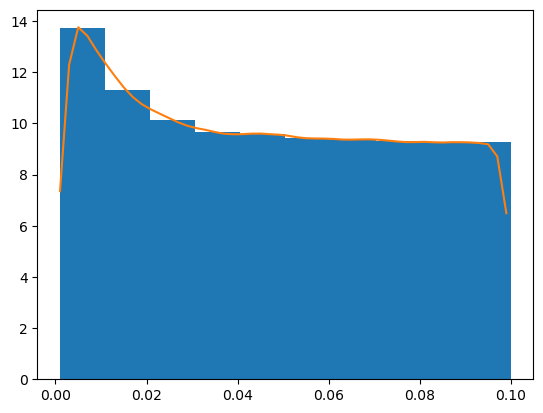

In [5]:
import emtk.curves.lorentzian as lor
import numpy as np
import matplotlib.pyplot as plt


curv = lor.LorentzianCurve()

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])
curv.generate_test_samples(pvalues, xrange, 100000)
curv.generate_background(xrange, 10.0)

est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(curv.data, density=True)
xgrid = np.arange(xrange[0], xrange[1], 0.002)
#xgrid = hh[1]
#xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)
ax.plot(xgrid, yvals)

In [3]:
print(np.sum(hh[0])*np.diff(hh[1]))
print(np.sum(yvals)*np.diff(xgrid))


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717 0.98813717
 0.98813717]


Problem solved!  Now to use it to do background subtraction...

# Background Subtraction

## Gaussian

Spectrum weight: 1.0
Background weight: 1.0
Ratio: 0.5
dice [0.54202617 0.07129734 0.64609763 ... 0.1206126  0.87542331 0.17649318]
x    [6.00141257 7.66696754 5.96541163 ... 2.76196215 6.20555807 5.75194545]
spec [0.17206799 0.0684093  0.17535766 ... 0.08063852 0.15244242 0.19358742]
back [0.12064371 0.11812455 0.12004473 ... 0.11331504 0.12353857 0.11614039]
rej  [0.70113975 1.72673229 0.68457075 ... 1.40522221 0.81039494 0.59993771]
masj [False  True False ...  True False  True]
# in  2000
# out 1073
survive fraction 0.5365


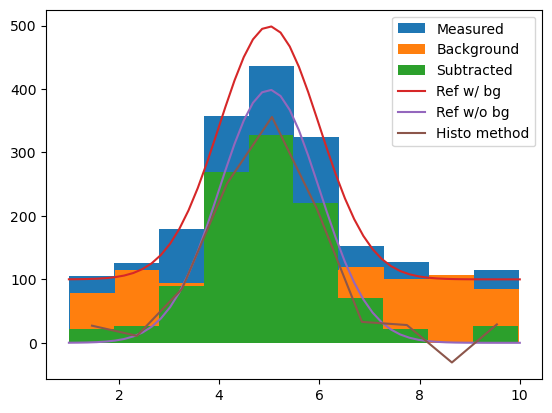

In [4]:
from scipy.stats import distributions

import numpy as np

import matplotlib.pyplot as plt

import emtk.curves
from emtk.omega.omegaFunctions import kde_background_subtract

xrange = [1,10]
nevents= 1000
nbackground =1000

spec_weight = 1.0
bg_weight = 1.0

mu = 5.0
sigma = 1.0
xgrid = np.linspace(*xrange)

ref = distributions.norm(mu, sigma)
bg = distributions.uniform(loc=xrange[0], scale = xrange[1]-xrange[0])

signal = ref.rvs(nevents)
background = bg.rvs(nbackground)
independentbg = bg.rvs(nbackground)

signal = signal[(signal > xrange[0]) & (signal < xrange[1])]

measurement = np.concatenate((signal, background))
np.random.shuffle(measurement)

subtr = kde_background_subtract(measurement, independentbg, spectrum_weight=spec_weight, background_weight=bg_weight, verbose=True)

hm=plt.hist(measurement, label='Measured')
hh=plt.hist(independentbg, label='Background')

xctr = hh[1] + 0.5*np.diff(hh[1])[0]
xctr = np.delete(xctr, -1)
plt.hist(subtr, label='Subtracted')
plt.plot(xgrid, (signal.size * ref.pdf(xgrid) + np.mean(hh[0])), label='Ref w/ bg')
plt.plot(xgrid, signal.size * ref.pdf(xgrid), label='Ref w/o bg')

plt.plot(xctr, hm[0]-hh[0], label='Histo method')
plt.legend()

In [8]:
hh[1]

array([1.00155506, 1.90129714, 2.80103922, 3.70078131, 4.60052339,
       5.50026547, 6.40000756, 7.29974964, 8.19949172, 9.0992338 ,
       9.99897589])

## A systematic Background

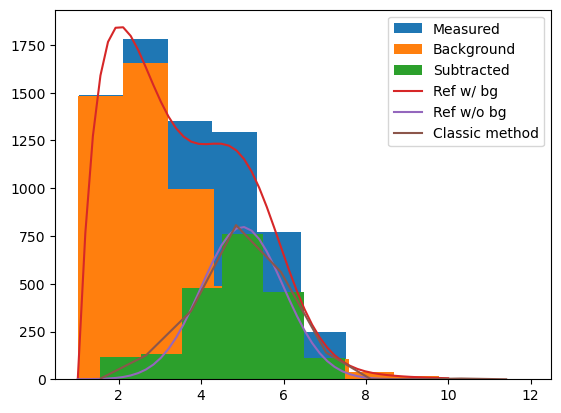

In [2]:
from scipy.stats import distributions

import numpy as np

import matplotlib.pyplot as plt

import emtk.curves
from emtk.omega.omegaFunctions import kde_background_subtract

xrange = [1,10]
nevents= 2000
nbackground =5000

mu = 5.0
sigma = 1.0
xgrid = np.linspace(*xrange)

ref = distributions.norm(mu, sigma)
bg = distributions.erlang(a=2.0, loc=xrange[0], scale = 1.0)

signal = ref.rvs(nevents)
background = bg.rvs(nbackground)
independentbg = bg.rvs(nbackground)

signal = signal[(signal > xrange[0]) & (signal < xrange[1])]

measurement = np.concatenate((signal, background))
# must shuffle the points, otherwise the two things are anti-correlated
np.random.shuffle(measurement)

subtr = kde_background_subtract(measurement, independentbg)

hm=plt.hist(measurement, label='Measured')
hh=plt.hist(independentbg, label='Background')

refw = nbackground * bg.pdf(xgrid) + nevents * ref.pdf(xgrid)

xctr = hh[1] + 0.5*np.diff(hh[1])[0]
xctr = np.delete(xctr, -1)
plt.hist(subtr, label='Subtracted')
plt.plot(xgrid, refw, label='Ref w/ bg')
plt.plot(xgrid, signal.size * ref.pdf(xgrid), label='Ref w/o bg')

plt.plot(xctr, hm[0]-hh[0], label='Classic method')
plt.legend()

# Which is faster, scikit-learn or scipy KDE?

The new omega code has both functions in it, since the scikit-learn trees implementation is supposed to be faster for larger data sets, and I noticed that the background subtraction code was almost unusable on the train home last night!

The result I expect to be similar to Jake VanderPlas' website here:
https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/


In [14]:
# setup

import time

from scipy.stats import distributions

import numpy as np

import matplotlib.pyplot as plt

import emtk.curves
from emtk.omega.omegaFunctions import kernel_density_sklearn
from emtk.omega.omegaFunctions import kernel_density_scipy


npts = 1000000

mu =50.0
sigma = 5.0

xgrid = np.arange(0, 100, 0.5)

gauss = distributions.norm(mu, sigma)
peak = gauss.rvs(npts)

ref = gauss.pdf(xgrid)
flat = np.random.uniform(0.0, 100.0, npts)

events = np.concatenate((peak, flat))
np.random.shuffle(events)



In [15]:
# Time the scipy KDE method

start_time = time.time()
scipy_line = kernel_density_scipy(events, xgrid)


print("--- scipy method: %s seconds ---" % (time.time() - start_time))

--- scipy method: 1.6885638236999512 seconds ---


In [16]:
# Time the scikit-learn KDE method

start_time = time.time()
sklearn_line = kernel_density_sklearn(events, xgrid, kernel='gaussian', rtol=1.0E-9)


print("--- scikit-learn method: %s seconds ---" % (time.time() - start_time))


--- scikit-learn method: 0.5141067504882812 seconds ---


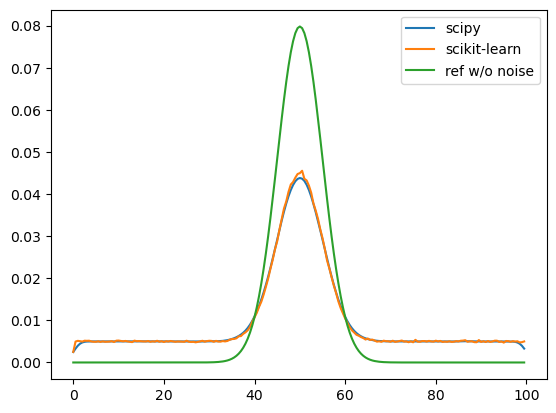

In [17]:
plt.plot(xgrid, scipy_line, label='scipy')
plt.plot(xgrid, sklearn_line, label='scikit-learn')
plt.plot(xgrid, ref, label='ref w/o noise')

plt.legend()